# Wheeled cat-catching robot (i.e., the "catbot")

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_catbot

pybullet build time: Sep  3 2024 12:57:43


Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `sound` (`True` or `False`) is whether or not to play sounds;
* `number_of_cats` (non-negative integer) is how many cats to launch.

If you want to test your controller with no cats, set `number_of_cats=0`.

In [2]:
simulator = ae353_catbot.Simulator(
    display=True,
    sound=True,
    number_of_cats=1,
)

argv[0]=
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


Choose a camera view from the following options:
* `camera_sideview()`
* `camera_wideview()`
* `camera_topview()`
* `camera_catview()`

In [3]:
simulator.camera_sideview()

Define a function that finds where the cat pilot will impact the robot, and calculates the necessary feedforward torque.

In [4]:
f, a, b, c = sym.symbols('f, a, b, c')

def checkHit(wheel, cat, t0):
    if(cat >= 0.0):
        xf = 0.5*(0.7 - f)*np.sqrt(2)
    else:
        xf = 0.5*(-0.7 + f)*np.sqrt(2)
    yf = 0.7 + 0.5*(0.7 - f)*np.sqrt(2)

    xa = wheel - cat - 0.5*np.cos(t0) + (0.7 + a)*np.sin(t0)
    ya = 0.5*np.sin(t0) + (0.7 + a)*np.cos(t0)

    xb = wheel - cat + 0.7*np.sin(t0) + (-0.5 + b)*np.cos(t0)
    yb = 0.7*np.cos(t0) + (0.5 - b)*np.sin(t0)

    xc = wheel - cat + 0.5*np.cos(t0) + (0.7 + c)*np.sin(t0)
    yc = -0.5*np.sin(t0) + (0.7 + c)*np.cos(t0)

    solA = sym.solve([xf - xa, yf - ya], [f, a])
    solB = sym.solve([xf - xb, yf - yb], [f, b])
    solC = sym.solve([xf - xc, yf - yc], [f, c])

    if(solA[a] <= 0.3 and solA[a] >= 0.0 and solA[f] <= 0.7 and solA[f] >= 0.0):
        x = xf.subs(f, solA[f])
        y = yf.subs(f, solA[f])
    elif(solB[b] <= 1.0 and solB[b] >= 0.0 and solB[f] <= 0.7 and solB[f] >= 0.0):
        x = xf.subs(f, solB[f])
        y = yf.subs(f, solB[f])
    elif(solC[c] <= 0.3 and solC[c] >= 0.0 and solC[f] <= 0.7 and solC[f] >= 0.0):
        x = xf.subs(f, solC[f])
        y = yf.subs(f, solC[f])
    else:
        x = 0.0
        y = 0.7
    
    L = sym.sqrt(x**2 + y**2)
    alpha = sym.atan(x/y)
    tau = L*np.sqrt(5000)*sym.cos(alpha + np.pi/4)
    return tau


Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the wheels. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [5]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            wheel_position,
            wheel_velocity,
            pitch_angle,
            pitch_rate, 
            cat_target,
        ):
        
        # FIXME: replace the following line
        xp = np.array([wheel_position - 1.1*cat_target, pitch_angle, wheel_velocity, pitch_rate])
        xt = np.array([pitch_angle, wheel_velocity - 1.5*(cat_target - wheel_position)/abs(cat_target - wheel_position), pitch_rate])
        K1 = np.array([ -1.41421356, -53.72890933 , -6.92587594, -10.76804196])
        K2 = np.array([-43.41831796 , -1.41421356, -7.88176632])
        K3 = np.array([ -3.  ,       -52.88076154 , -6.96223104 ,-10.49411143])
        if(abs(wheel_position - cat_target) >= 1.0):
            wheel_torque = -K2@xt
        else:
            if(abs(wheel_velocity) <= 0.25):
                wheel_torque = -K3@xp
            else:
                wheel_torque = -K1@xp

        if (abs(t - 5.99) < 0.10):
            if (cat_target < 0.0):
                tau_e = checkHit(wheel_position, cat_target, pitch_angle)
            else:
                tau_e = -1*checkHit(wheel_position, cat_target, pitch_angle)
        else:
            tau_e = 0.0
        wheel_torque = wheel_torque + tau_e
        return wheel_torque

Create an instance of the controller.

In [6]:
controller = Controller()

Reset the simulator with given initial conditions.

In [7]:
simulator.reset(
    initial_wheel_position=0.,
    initial_wheel_velocity=0.,
    initial_pitch_angle=0.,
    initial_pitch_rate=0.,
)

Reset the controller.

In [8]:
controller.reset()

Run the simulator.

A cat will launch after one second, and then every six seconds thereafter. So, you may want to choose `maximum_time` as follows:
* `maximum_time=6.99` if you want to catch one cat;
* `maximum_time=12.99` if you want to catch two cats;
* `maximum_time=18.99` if you want to catch three cats;
* ... and so forth.

In [9]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time=10.0,    # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

/var/folders/9s/kcz79dxx7lq8r_fg5f78gp580000gn/T/ipykernel_55112/2427771156.py:20: RuntimeWarning: invalid value encountered in scalar divide
  xt = np.array([pitch_angle, wheel_velocity - 1.5*(cat_target - wheel_position)/abs(cat_target - wheel_position), pitch_rate])


Count the number of saved cats.

In [10]:
number_of_cats_saved = simulator.get_number_of_cats_saved()
print(f'{number_of_cats_saved} cats were saved')

1 cats were saved


Get, show, and save a snapshot of the simulation after the last time step.

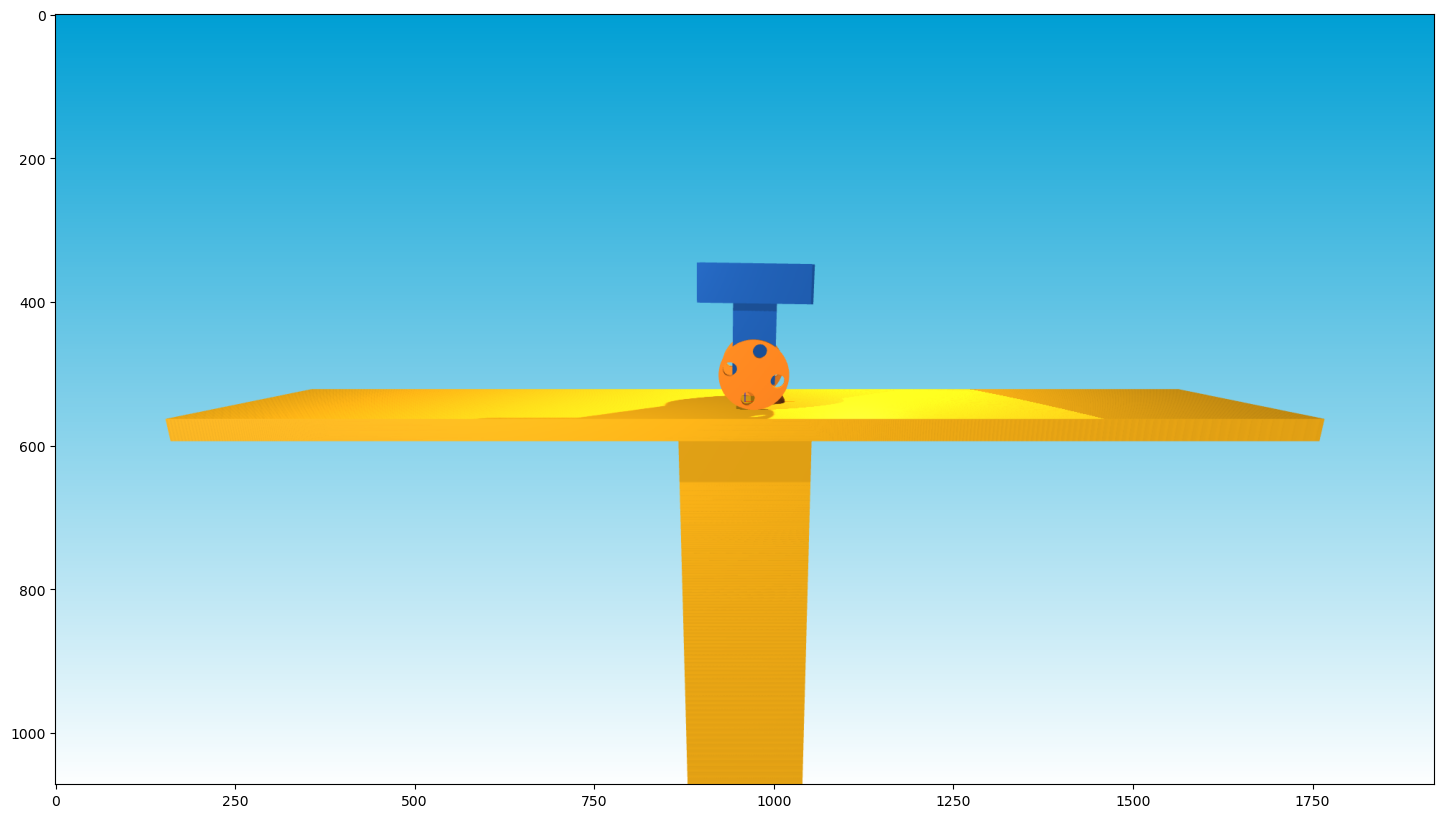

In [11]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(20, 10))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

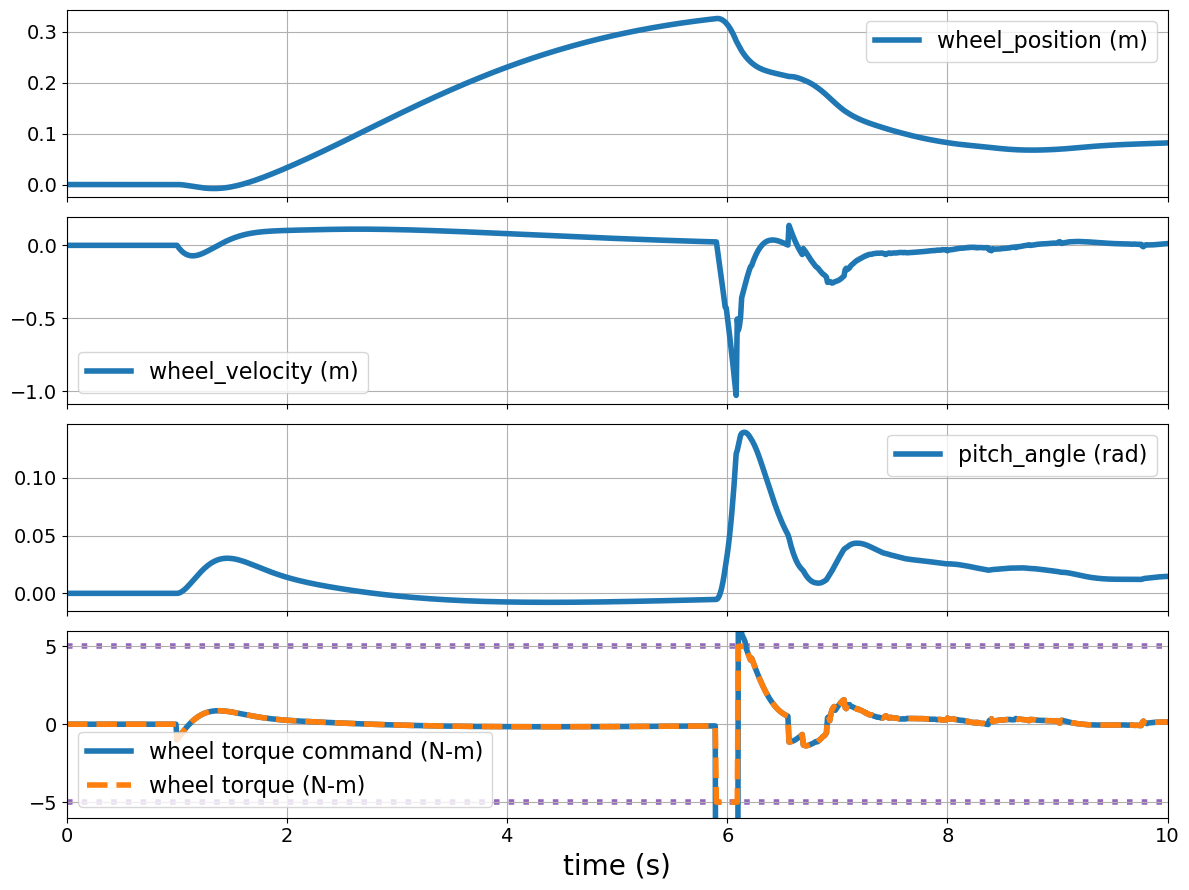

In [12]:
# Create a figure with five subplots, all of which share the same x-axis
fig, (
    ax_wheel_position,
    ax_wheel_velocity,
    ax_pitch_angle,
    #ax_pitch_rate,
    ax_wheel_torque,
) = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

# Plot wheel position
ax_wheel_position.plot(
    data['t'], data['wheel_position'],
    label='wheel_position (m)', linewidth=4,
)
ax_wheel_position.grid()
ax_wheel_position.legend(fontsize=16)
ax_wheel_position.tick_params(labelsize=14)

# Plot wheel velocity
ax_wheel_velocity.plot(
    data['t'], data['wheel_velocity'],
    label='wheel_velocity (m)', linewidth=4,
)
ax_wheel_velocity.grid()
ax_wheel_velocity.legend(fontsize=16)
ax_wheel_velocity.tick_params(labelsize=14)

# Plot pitch angle
ax_pitch_angle.plot(
    data['t'], data['pitch_angle'],
    label='pitch_angle (rad)', linewidth=4,
)
ax_pitch_angle.grid()
ax_pitch_angle.legend(fontsize=16)
ax_pitch_angle.tick_params(labelsize=14)

# Plot pitch rate
#ax_pitch_rate.plot(
#    data['t'], data['pitch_rate'],
#    label='pitch_rate (rad)', linewidth=4,
#)
#ax_pitch_rate.grid()
#ax_pitch_rate.legend(fontsize=16)
#ax_pitch_rate.tick_params(labelsize=14)

# Plot wheel torque
ax_wheel_torque.plot(
    data['t'], data['wheel_torque_command'],
    label='wheel torque command (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], data['wheel_torque'],
    '--', label='wheel torque (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.grid()
ax_wheel_torque.legend(fontsize=16)
ax_wheel_torque.tick_params(labelsize=14)
ax_wheel_torque.set_ylim(
    -1.2 * simulator.maximum_wheel_torque,
    1.2 * simulator.maximum_wheel_torque,
)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_wheel_torque.set_xlabel('time (s)', fontsize=20)
ax_wheel_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [13]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)